In [1]:
# import packages
import torch
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from qiskit_machine_learning.utils import algorithm_globals
from torch import nn
import pandas as pd
from scipy.stats import rankdata
import torch.nn.functional as F


In [2]:
#load dataset

sp500 = yf.download('^GSPC', start='2016-01-01', end='2024-12-31')
dowjones = yf.download('^DJI', start='2016-01-01', end='2024-12-31')

# Compared to the Apple and Microsoft plot they have in the paper, this gives a similar result. To get it using amplitude encoding,
# we do need to preprocess the data as we were doing before, so putting it in a probability distribution.
sp500_returns = sp500['Close'].pct_change().dropna()
sp_returns = sp500['Close'].dropna().values

dowjones_returns = dowjones['Close'].pct_change().dropna()
dj_returns = dowjones['Close'].dropna().values


# encode in state amplitude
# We have 8192 datapoints, so we need 13 qubits to encode them
num_qubits = 3

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


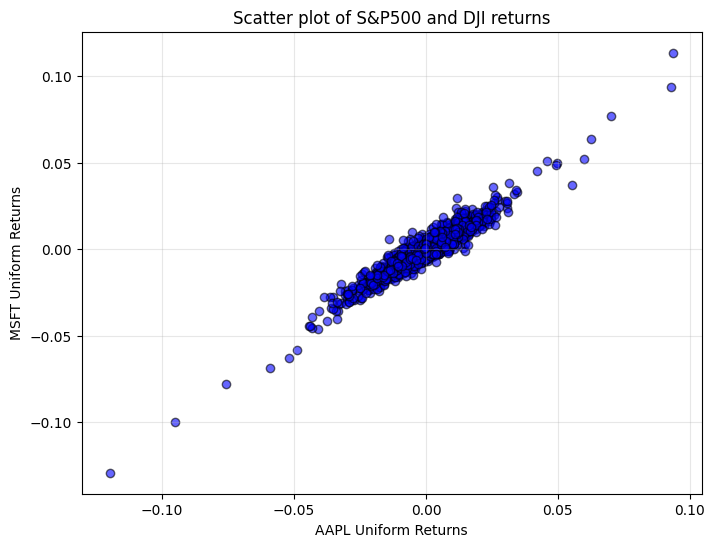

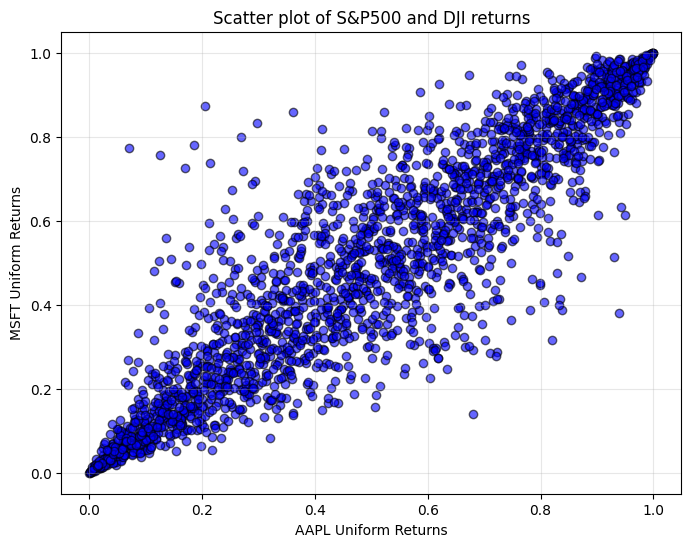

In [3]:
def empirical_cdf(data):
    ranks = rankdata(data, method='average')  # Rank the data
    uniform_data = ranks / (len(data) + 1)    # Normalize to [0, 1]
    return uniform_data

sp500_uniform = empirical_cdf(sp500_returns)
dj_uniform = empirical_cdf(dowjones_returns)

# Plot the scatter plot of returns
plt.figure(figsize=(8, 6))
plt.scatter(sp500_returns, dowjones_returns, alpha=0.6, c='blue', edgecolor='k')
plt.title("Scatter plot of S&P500 and DJI returns")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.show()


# Plot the scatter plot of uniform returns
plt.figure(figsize=(8, 6))
plt.scatter(sp500_uniform, dj_uniform, alpha=0.6, c='blue', edgecolor='k')
plt.title("Scatter plot of S&P500 and DJI returns")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.show()

In [4]:
data_stack = np.column_stack((sp500_uniform,dj_uniform))
df2 = pd.DataFrame({
    'SP500': sp500_uniform,
    'DJI': dj_uniform
})

In [5]:
from copulas.bivariate import Clayton

copulas = Clayton()
copulas.fit(data_stack)

samples = copulas.sample(len(data_stack))
samples = pd.DataFrame(samples, columns=['SP500', 'DJI'])
print(samples)

         SP500       DJI
0     0.813326  0.787381
1     0.787565  0.912080
2     0.936875  0.669700
3     0.213903  0.179544
4     0.699976  0.432883
...        ...       ...
2257  0.362215  0.223427
2258  0.973314  0.708711
2259  0.912103  0.741298
2260  0.984409  0.880534
2261  0.877065  0.870206

[2262 rows x 2 columns]


In [6]:
from copulas.visualization import compare_2d
compare_2d(df2, samples)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Data=Real<br>SP500=%{x}<br>DJI=%{y}<extra></extra>',
              'legendgroup': 'Real',
              'marker': {'color': '#000036', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Real',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([0.5890411 , 0.07777287, 0.02651348, ..., 0.42377375, 0.09854176,
                          0.10384445]),
              'xaxis': 'x',
              'y': array([0.49270879, 0.05832965, 0.02342024, ..., 0.49624392, 0.1369863 ,
                          0.10737958]),
              'yaxis': 'y'},
             {'hovertemplate': 'Data=Synthetic<br>SP500=%{x}<br>DJI=%{y}<extra></extra>',
              'legendgroup': 'Synthetic',
              'marker': {'color': '#01E0C9', 'symbol': 'diamond'},
              'mode': 'markers',
              'name': 'Synthetic',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([0.81332617, 0.78756546, 0.93687505, ..., 0.91210334, 0.98440871,
                          0.87706502]),
              'xaxis': 'x',
              'y': array([0.78738069, 0.91207987, 0.66969983, ..., 0.74129792, 0.88053387,
                          0.87020588]),
              'yaxis': 'y'}],
    'layout': {'font': {'size': 18},
               'legend': {'title': {'text': 'Data'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'plot_bgcolor': '#F5F5F8',
               'showlegend': True,
               'template': '...',
               'title': {'text': "Real vs. Synthetic Data for columns 'SP500' and 'DJI'"},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'SP500'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'DJI'}}}
})

In [7]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RXXGate

def create_bell_pair_circuit(num_qubits=num_qubits):
    # Create two quantum registers A and B with num_qubits each
    qr_a = QuantumRegister(num_qubits, 'A')
    qr_b = QuantumRegister(num_qubits, 'B')
    qc = QuantumCircuit(qr_a, qr_b)

    # Step 1: Apply H gates to all qubits in register A
    qc.h(qr_a)

    # Step 2: Apply CNOT gates between corresponding qubits in A and B
    for i in range(num_qubits):
        qc.cx(qr_a[i], qr_b[i])

    return qc


In [8]:
# define generator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import RZGate, RXGate, CXGate, RXXGate

shot = 4096
class QuantumGenerator:
    def __init__(self, num_qubits, layers=1):
        self.num_qubits = num_qubits
        self.layers = layers
        self.params = np.random.uniform(0, 2 * np.pi, size=(layers, 2 * num_qubits))
        self.backend = AerSimulator()

    def set_params(self, params):
        # Update the generator's parameters
        self.params = params
        
    def _build_circuit(self, params):
        

        # Ensure params are a NumPy array
        params = np.array(params)  # Ensure parameters are in NumPy format

        # Build a two-register circuit so the measurement yields 2*num_qubits bits:
        def add_unitary_layers(qc, qr, num_layers):
            num_qubits = len(qr)
            for layer in range(num_layers):
                for i in range(num_qubits):
                    qc.rz(float(params[layer, 2 * i]), qr[i])
                    qc.rx(float(params[layer, 2 * i + 1]), qr[i])
                    qc.rz(float(params[layer, 2 * i]), qr[i])
                for i in range(num_qubits - 1):
                    qc.append(RXXGate(float(params[layer, 2 * i])), [qr[i], qr[i+1]])
            return qc

        qr_a = QuantumRegister(self.num_qubits, 'A')
        qr_b = QuantumRegister(self.num_qubits, 'B')
        qc = create_bell_pair_circuit(self.num_qubits)
        qc = add_unitary_layers(qc, qr_a, self.layers)
        qc = add_unitary_layers(qc, qr_b, self.layers)
        qc.measure_all()
        return qc
    
    def draw_circuit(self):
        qc = self._build_circuit(self.params)
        return qc.draw(output='mpl',style='clifford')
    
    def num_params(self):
        qc = self._build_circuit(self.params)
        return qc.num_parameters


    def generate_samples(self):
        qc = self._build_circuit(self.params)
        qc = transpile(qc, self.backend)
        result = self.backend.run(qc, shots=shot).result()
        counts = result.get_counts()
        counts_list = list(counts.items())
        #counts_list.extend([0]*(shots - len(counts_list)))
        #print(counts_list)
        return counts_list

# define discriminator 
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 32)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [9]:
quantum_gen = QuantumGenerator(num_qubits, layers=1)
discriminator = Discriminator(2)

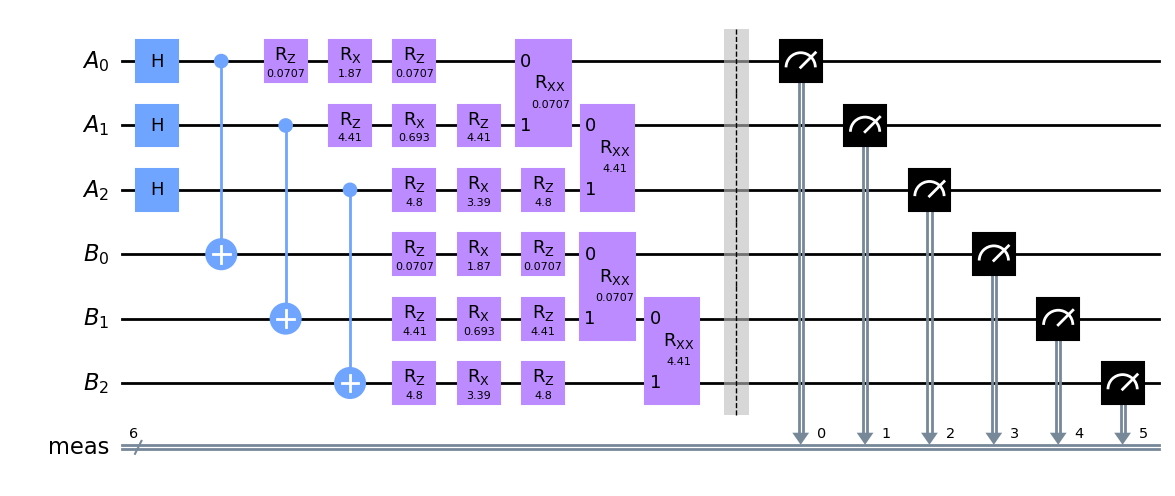

In [10]:
quantum_gen.draw_circuit()

In [11]:
len(quantum_gen.generate_samples())

57

In [12]:
quantum_gen.num_params()

0

In [13]:
# define loss functions
# BCE loss function
def adversarial_loss(input, target):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    total_loss = -torch.mean(bce_loss)
    return total_loss

# WGAN loss function
def wgan_loss(pred, target_is_real):
    return -torch.mean(pred) if target_is_real else torch.mean(pred)

In [14]:
def discriminator_loss(discriminator, real_data, fake_data):
    """
    Calculate the loss for the discriminator.

    Args:
        discriminator (nn.Module): The discriminator model.
        real_data (torch.Tensor): Batch of real data samples.
        fake_data (torch.Tensor): Batch of fake data samples generated by the generator.

    Returns:
        torch.Tensor: Discriminator loss.
    """
    epsilon = 1e-8  # To avoid log(0)
    real_loss = torch.log(discriminator(real_data) + epsilon).mean()
    fake_loss = torch.log(1 - discriminator(fake_data) + epsilon).mean()
    return -(real_loss + fake_loss) / 2

def generator_loss(discriminator, fake_data):
    """
    Calculate the loss for the generator.

    Args:
        discriminator (nn.Module): The discriminator model.
        fake_data (torch.Tensor): Batch of fake data samples generated by the generator.

    Returns:
        torch.Tensor: Generator loss.
    """
    epsilon = 1e-8  # To avoid log(0)
    return -torch.log(discriminator(fake_data) + epsilon).mean()

In [15]:
def spsa_gradient_estimator(C, theta_k, c, delta_k):
    """
    Estimate the gradient using SPSA with PyTorch tensors.
    
    Args:
        C (callable): Cost function to minimize.
        theta_k (torch.Tensor): Current parameters.
        c (float): Perturbation scaling factor.
        delta_k (torch.Tensor): Random perturbation vector.

    Returns:
        torch.Tensor: Estimated gradient.
    """
    perturbed_theta_plus = theta_k + c * delta_k
    perturbed_theta_minus = theta_k - c * delta_k
    # Compute the cost function for perturbed parameters
    C_plus = C(perturbed_theta_plus)
    C_minus = C(perturbed_theta_minus)
    # Gradient estimator formula
    gradient_estimate = (C_plus - C_minus) / (2 * c * delta_k)
    return gradient_estimate

def spsa_update(theta_k, C, a, c, gamma, k):
    """
    Perform one step of SPSA update using PyTorch tensors.
    
    Args:
        theta_k (torch.Tensor): Current parameters.
        C (callable): Cost function to minimize.
        a (float): Learning rate parameter.
        c (float): Perturbation parameter.
        gamma (float): Decay exponent for learning rate.
        k (int): Current iteration.

    Returns:
        torch.Tensor: Updated parameters.
    """
    # Generate random perturbation vector delta_k
    delta_k = torch.randint(0, 2, theta_k.shape, dtype=torch.float32) * 2 - 1  # Random {-1, 1}
    
    # Estimate the gradient using SPSA
    gradient_estimate = spsa_gradient_estimator(C, theta_k, c, delta_k)
    
    # Update the parameters
    theta_k_plus_1 = theta_k - (a / (k ** gamma)) * gradient_estimate
    return theta_k_plus_1
# Adam optimizer
from torch.optim import Adam

# Adam constants
lr = 0.0001  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter
d_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [16]:
import torch
import torch.nn.functional as F

def pad_tensor_2d(tensor, desired_length):
    current_length = tensor.size(0)  # Get current number of rows
    if current_length < desired_length:
        # Calculate how much padding is needed
        padding_length = desired_length - current_length
        
        # Apply padding only along the first dimension (rows)
        padded_tensor = F.pad(tensor, (0, 0, 0, padding_length), "constant", 0)
        return padded_tensor
    else:
        return tensor  # If tensor already has the desired length or more, return unchanged
    
def plot_training_progress(all_generated_data, real_data, g_losses, d_losses, epoch):
    
    # Plot 2: Moving average of last 100 epochs
    if len(all_generated_data) >= 100:
        recent_data = all_generated_data[-100:]
        avg_data = np.mean(recent_data, axis=0)
        plt.scatter(avg_data[:,0], avg_data[:,1], c='red', alpha=0.5, 
                   label='Avg Generated (Last 100)')
        plt.scatter(real_data[:,0], real_data[:,1], c='blue', alpha=0.5, 
                   label='Real Data')
    plt.title('Moving Average (Last 100 epochs)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_evolving_averages(all_generated_data, real_data, epoch, window=100):
    plt.clf()
    fig = plt.figure(figsize=(12,8))
    
    # Plot real data as reference
    plt.scatter(real_data[:,0], real_data[:,1], 
               c='blue', alpha=0.5, label='Real Data')
    
    # Calculate and plot averages for each 100-epoch window
    for i in range(0, len(all_generated_data), window):
        if i + window <= len(all_generated_data):
            window_data = all_generated_data[i:i+window]
            avg_data = np.mean(window_data, axis=0)
            
            # Newer averages are more opaque
            alpha = (i + window) / len(all_generated_data)
            plt.scatter(avg_data[:,0], avg_data[:,1],
                       alpha=min(0.8, alpha),
                       label=f'Epochs {i}-{i+window}')
    
    plt.title(f'Evolution of Generated Data Averages - Epoch {epoch}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.pause(0.01)

print(list(np.random.randint(0, 2, 18)))

[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]


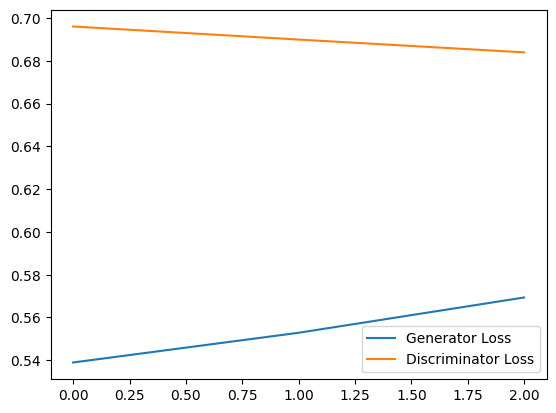

Finished epoch 3
torch.Size([128, 2])
tensor([[0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.0625, 0.0625],
        [0.9375, 0.6875],
        [0.5625, 0.5625],
        [0.6875, 0.4375],
        [1.0625, 0.9375],
        [0.4375, 1.0625],
        [0.6875, 1.0625],
        [0.6875, 1.1875],
        [0.8125, 1.3125],
        [0.6875, 0.6875],
        [0.9375, 0.5625],
        [0.9375, 1.1875],
        [0.8125, 0.9375],
        [0.9375, 0.3125],
        [1.0625, 0.9375],
        [0.9375, 1.0625],
        [0.9375, 0.8125],
        [0.9375, 0.9375],
        [0.8125, 1.1875],
        [0.9375, 0.8125],
        [0.8125, 0.9375],
        [0.6875, 0.6875],


KeyboardInterrupt: 

In [17]:
# Define training function
from IPython.display import clear_output

def train():
    # SPSA constants
    a = 0.008
    c = 0.01
    gamma = 0.101

    quantum_gen_params = quantum_gen.params

    iterations = 1000
    batch_size = 128
    d_losses = []
    g_losses = []
    all_generated_data = []
    for epoch in range(iterations):
        d_loss_epoch = 0
        g_loss_epoch = 0
        #print('beep')

        #quantum_gen.draw_circuit()
        #print('boop')

        # Loop over batches
        for j in range(0, int(shot/batch_size)):  # Use length of the 'samples' DataFrame
            start_idx = batch_size*j
            #print(start_idx)
            end_idx = batch_size*(j+1)
            #print(end_idx)
            #print('samp length: ' + str(len(samples)))
            #print('batch nb: '+ str(batch_idx))
            # Generate quantum data
            #print(len(quantum_gen.generate_samples()))
            quantum_samples = quantum_gen.generate_samples()
            
 
            pqm = []

            for bitstring, count in quantum_samples:
            # Convert the bitstring into a list of integers (each qubit measurement)
                qubit_measurements = list(map(int, bitstring))
                # Repeat the qubit measurements based on the count
                for _ in range(count):
                    extended_bitstring = qubit_measurements + list(np.random.randint(0, 2, num_qubits*6))  # Append 18 bits of random noise
                    # print(len(extended_bitstring))
                    pqm.append(extended_bitstring)
            noise_x = np.random.uniform(-1/(2**num_qubits), 1/(2**num_qubits))
            noise_y = np.random.uniform(-1/(2**num_qubits), 1/(2**num_qubits))
    
    
            # Convert quantum samples to copula space
            q_data = []
            x_samples = []
            y_samples = []
            for idx in range(batch_size):
                x_samples.append([1/2**(1+num_qubits) + sum(pqm[start_idx:end_idx][idx][i]/2**num_qubits for i in pqm[start_idx:end_idx][idx][:num_qubits*4])])
                y_samples.append([1/2**(1+num_qubits) + sum(pqm[start_idx:end_idx][idx][i]/2**num_qubits for i in pqm[start_idx:end_idx][idx][num_qubits*4:])])
            q_data = torch.cat((torch.tensor(x_samples),torch.tensor(y_samples)), dim = 1)
            print(q_data.shape)
            # q_data = pad_tensor_2d(q_data,batch_size)
            print(q_data)
            #print('x samples: ' + str(len(x_samples)))
            #print('y samples: ' + str(len(y_samples)))
            #print('quantum data: ' +str(q_data.shape))

            # Get real data from samples dataframe
            real_batch = samples.iloc[0:batch_size]
            real_data = torch.tensor(real_batch[['SP500', 'DJI']].values, dtype=torch.float32)
            #print('real data: '+ str(real_data.shape))

            real_labels = torch.ones((batch_size, 1))
            fake_labels = torch.zeros((batch_size, 1))
            #print('real labels: ' + str(real_labels.shape))
            #print('fake labels: ' + str(fake_labels.shape))

            # Train the discriminator
            d_loss = discriminator_loss(discriminator, real_data, q_data)
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            d_loss_epoch += d_loss.item()
            #print(f"finished batch {j+1}")
        # Define cost_function for SPSA
        def cost_function(theta_k):
            quantum_gen.params = torch.tensor(theta_k)
            return generator_loss(discriminator, q_data).item()
        # Perform the SPSA update on the quantum generator parameters
        quantum_gen_params = spsa_update(torch.tensor(quantum_gen_params), cost_function, a, c, gamma, epoch + 1)
        

        # Record the losses
        g_losses.append(generator_loss(discriminator, q_data).item())
        d_losses.append(d_loss_epoch / (shot / batch_size))
        clear_output(wait=True)
        if epoch % 100 == 0:
            plot_evolving_averages(all_generated_data, real_data.detach().numpy(), epoch)
        plt.plot(np.array(g_losses), label="Generator Loss")
        plt.plot(np.array(d_losses), label="Discriminator Loss")
        plt.legend()
        plt.show()
        print(f"Finished epoch {epoch+1}")
        
        
        
train()

In [58]:
plt.plot(q_data)

NameError: name 'q_data' is not defined